### Exploring Adversarial Explanations with Fashion MNIST

Yeah yeah fashion mnist is boring... this is just a proof of concept to get some familiarity with adversarial examples as they relate to model explanations. The model is basic, don't judge. 

The paper we're implementing this week is [`Explanations Can Be Manipulated and Geometry is to Blame`](https://arxiv.org/abs/1906.07983), presented at NeurIPS 2019. To implement this we needed a deep network explainer, so I also implemented Integrated Gradients from the paper [`Axiomatic Attribution for Deep Networks`](https://arxiv.org/pdf/1703.01365.pdf). 

This notebook is mainly focused on exploring the results, but if you're interested in the details of the implementation I encourage you to read the papers over and check out the helper files `integrated_gradients.py` and `adversarial_explanations.py`. They're commented with details of what I'm doing to 1. explain my models and 2. create these adversarial explanations. 

For now, enjoy this sneaky doggo:

<img src="images/manipulated_explanation.png" alt="drawing" width="250" align="justify"/>

In [1]:
# import the necessities
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

print(tf.__version__)

2.1.0


In [2]:
# Load and scale data
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images/255.0
test_images = test_images/255.0


In [3]:
class_names = ['Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


This is a Coat:


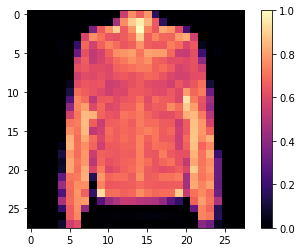

This is a Top:


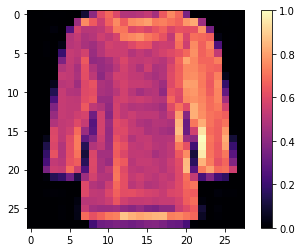

This is a Shirt:


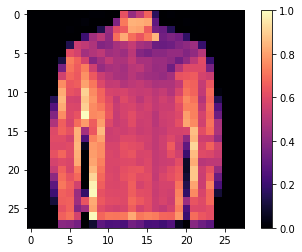

This is a Pullover:


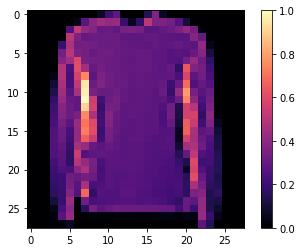

This is a Sandal:


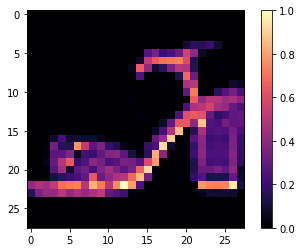

In [4]:
# Magma color map is rad af
np.random.seed(1738)
for i in np.random.choice(train_images.shape[0], size=5):
    print('This is a {}:'.format(class_names[train_labels[i]]))
    plt.figure()
    plt.imshow(train_images[i], cmap='magma')
    plt.colorbar()
    plt.grid(False)
    plt.show()
    

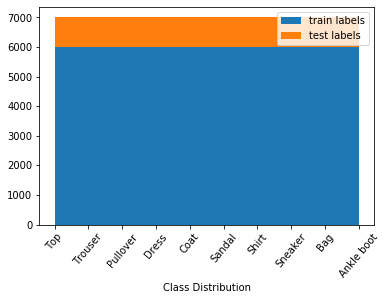

In [5]:
# Check class distribution-- all even, that's nice
degrees = 50
plt.hist([train_labels, test_labels], stacked=True)
plt.xticks(np.arange(10), class_names, rotation=degrees)
plt.legend(['train labels', 'test labels'])
plt.xlabel('Class Distribution')
plt.show()


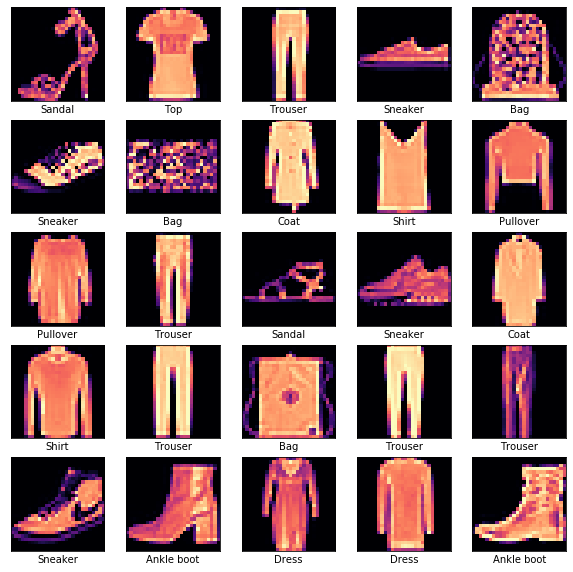

In [6]:
np.random.seed(108)
plt.figure(figsize=(10,10))
j=0
for i in np.random.choice(train_images.shape[0], size=25):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='magma')
    plt.xlabel(class_names[train_labels[i]])
    j+=1
plt.show()

## Custom Loss Function

The paper requires the use of a twice-differentiable loss function in the model, which because of the disconintnuous gradient rules out Relu. To get around this, the authors suggest implementing a beta-softmax, which with a high-b value mimic the behavior of a Relu. See the demonstration below. The authors also suggest that lowering this b-value can help improve the stability of explanations, or more accurately can make them less suceptible to adversarial weaknesses. 

Unfortunately, because of numeric stability issues, this loss can be tricky to work with when it comes to training the model and creating an adversarial explanation. The default model in the notebook will use a sigmoid, which is also twice differentiable and much more stable, but I encourage the reader to try out the beta-softmax below! I'll leave a commented out line to make it easy. You have to hard-code the beta value, but play around with some different ones!


Beta value of 0.1


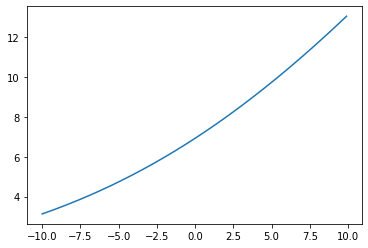

Beta value of 0.2


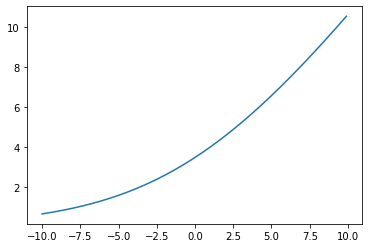

Beta value of 0.5


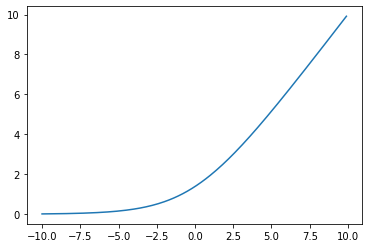

Beta value of 1


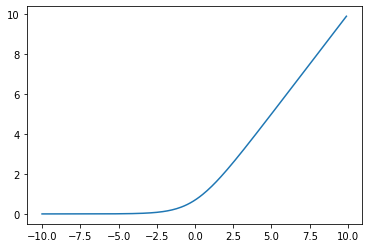

Beta value of 2


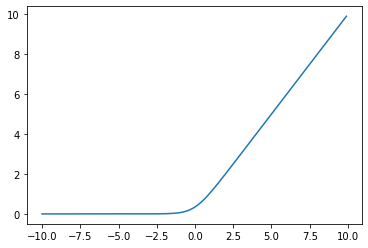

Beta value of 5


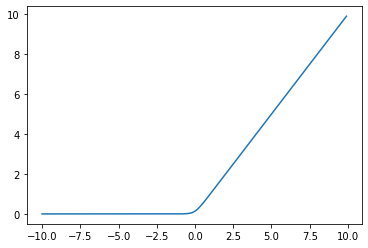

Beta value of 10


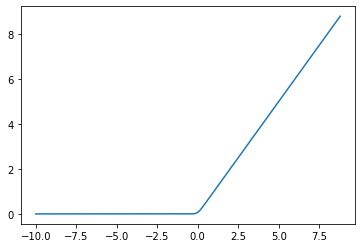

In [7]:
""" Custom Loss Function """
# Unfortunately TF does not support a B-softplus
# We'll need to construct our own:
# 𝑓(𝑥)=(1/𝛽)log(1+exp(𝛽𝑥))
# Note that as the value of Beta increases
# The function mimics a Relu
# (But it is twice-differentiable)

from tensorflow import math
def b_softmax(x, b):
    # Need to cast as a float for TF to behave
    x = tf.dtypes.cast(x,tf.float32)
    b = tf.dtypes.cast(b,tf.float32)
    return math.multiply(math.divide(1, b), math.log(math.add(1, math.exp(math.multiply(b, x)))))

beta_vals = [0.1, 0.2, 0.5, 1, 2, 5, 10]
for val in beta_vals:
    points = np.arange(-10, 10, step = 0.1)
    print('Beta value of {}'.format(val))
    vals = [b_softmax(x, val) for x in points]                                              
    plt.plot(points, vals)
    plt.show()


## Training the Model

In [60]:
#os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(108)

def b_softmax_2(x):
    # Need to cast as a float32 for TF to behave
    x = tf.dtypes.cast(x,tf.float32)
    return math.multiply(math.divide(1., 2.), math.log(math.add(1., math.exp(math.multiply(2., x)))))

def b_softmax_0_8(x):
    # Need to cast as a float32 for TF to behave
    x = tf.dtypes.cast(x,tf.float32)
    return math.multiply(math.divide(1., 0.8), math.log(math.add(1., math.exp(math.multiply(0.8, x)))))

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    # To try:
    # keras.layers.Dense(128, activation=b_softmax_2), - closer to Relu behavior
    # keras.layers.Dense(128, activation=b_softmax_0_8), #- authors suggested value
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10)

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)



Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 120us/sample - loss: 0.6560 - accuracy: 0.7627
Epoch 2/10
60000/60000 [==============================] - 7s 110us/sample - loss: 0.3926 - accuracy: 0.8574
Epoch 3/10
60000/60000 [==============================] - 9s 145us/sample - loss: 0.3539 - accuracy: 0.8709
Epoch 4/10
60000/60000 [==============================] - 8s 132us/sample - loss: 0.3287 - accuracy: 0.8789
Epoch 5/10
60000/60000 [==============================] - 7s 123us/sample - loss: 0.3093 - accuracy: 0.8861
Epoch 6/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2956 - accuracy: 0.8906
Epoch 7/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2815 - accuracy: 0.8962
Epoch 8/10
60000/60000 [==============================] - 8s 139us/sample - loss: 0.2723 - accuracy: 0.8985
Epoch 9/10
60000/60000 [==============================] - 7s 116us/sample - loss: 0.2612 - accuracy: 0.9019
Epoch

In [61]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])


In [62]:
predictions = probability_model.predict(test_images)


In [63]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                        100*np.max(predictions_array),
                                        class_names[true_label]),
                                        color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    


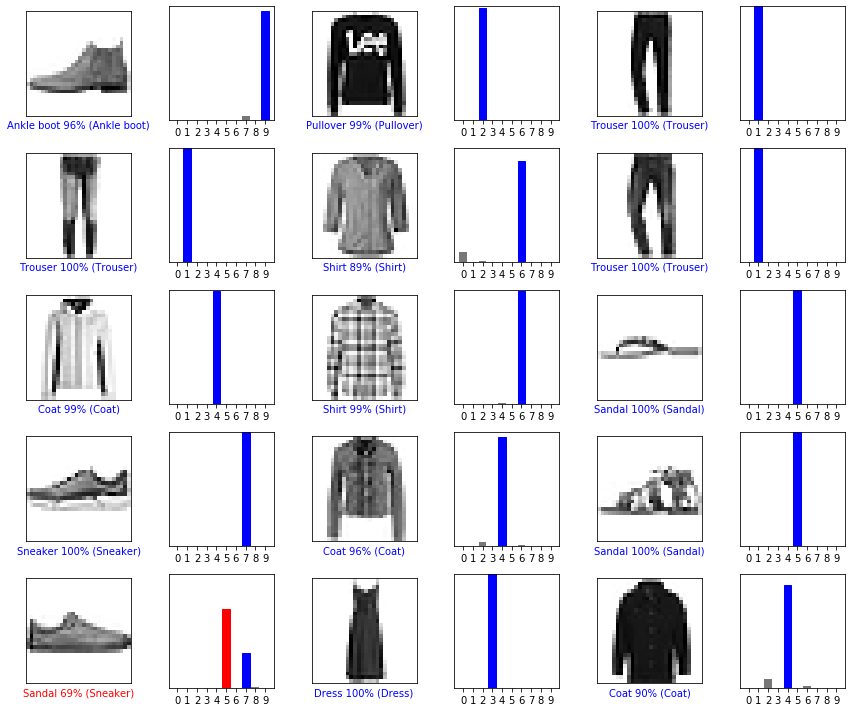

In [64]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()


## Integrated Gradients

For details on parameterization and integrated gradients, see `integrated_gradients.py.` Here we're going to just get a feel for IG, and see some of the cool results. 

IG is basically an application of the fundamental theorem of calculus (a nice intuitive explanation of which is [here](https://math.stackexchange.com/a/1537836)), where we decompose the score of a deep network by integrating the gradient of the model's score between a baseline input and an observation we want to explain.

The resulting explanation is a feature-wise breakdown of the difference between the model's score at the baseline and observation of interest in terms of the positive and negative influences each feature had. In laymans terms, this tells you how each feature helped or hurt a given score. 

For many problems there is a natural baseline to "explain" observations by-- for computer vision, many folks use an all zero background (but there're benefits to other baselines! See the awesome article [here](https://distill.pub/2020/attribution-baselines/).)

Below we're going to parameterize the path between an "all zeros" baseline and an observation whose score we will explain to get a feel for what path-attribution means. 

Then we will explore an explanation to see how increasing the number of steps on our integration path changes the accuracy of our integration.


0 Steps:


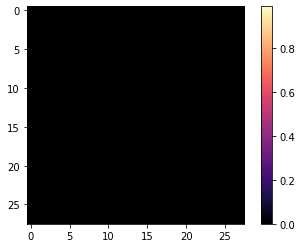

10 Steps:


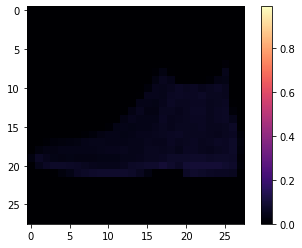

20 Steps:


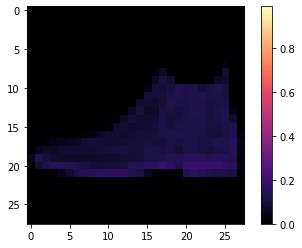

30 Steps:


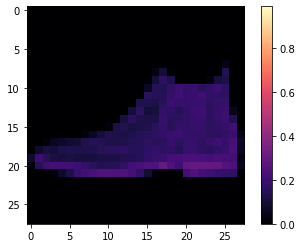

40 Steps:


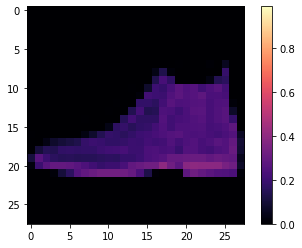

50 Steps:


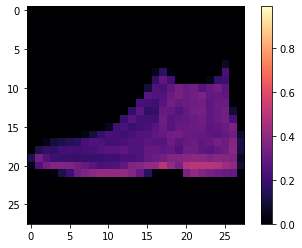

60 Steps:


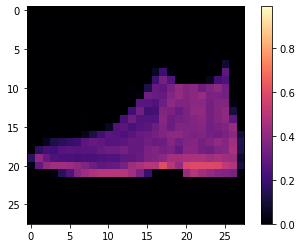

70 Steps:


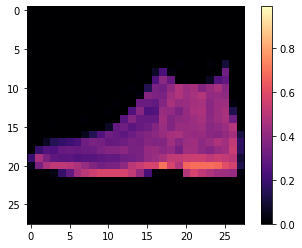

80 Steps:


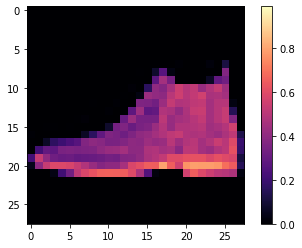

99 Steps:


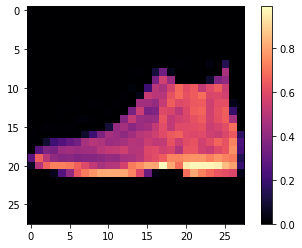

In [65]:
from integrated_gradients import _parameterize

baseline = np.zeros((test_images[0].shape[0],test_images[0].shape[1]))

# Parameterize with our IG helper function
steps, step = _parameterize(ob=test_images[0], base=baseline, n_steps=100)

# We're going to see snapshots of the parameterization at 10-step intervals
intervals = [0, 10, 20, 30, 40, 50, 60, 70, 80, 99]

# Normalize color pallet, otherwise auto-normalization will kill the effect here
norm = matplotlib.colors.Normalize(vmin=min(np.asarray(steps[99]).flatten()), 
                                   vmax=max(np.asarray(steps[99]).flatten()), 
                                   clip=False)

for i in intervals:
    print('{} Steps:'.format(i))
    plt.figure()
    plt.imshow(steps[i], cmap='magma', norm=norm)
    plt.colorbar()
    plt.grid(False)
    plt.show()


It makes sense that as we "walk the path" from an all zero (i.e.- all black) baseline to the image we want to explain, it looks like a faint image appears and gets brighter and brighter. 

Importantly, however, we don't necessarily need to use an all black baseline. We could want to explain the difference between the scores of a shoe and a shirt. Then, we could set the "baseline" as a shirt and the "observation" as the shoe and get a path between those two: 


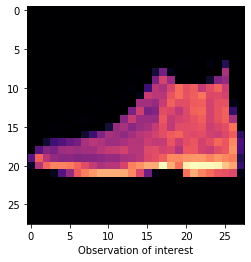

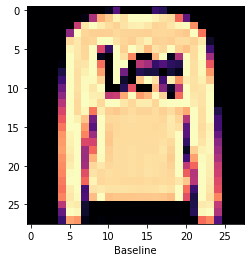

In [66]:
plt.figure()
plt.imshow(test_images[0], cmap='magma', norm=norm)
plt.xlabel('Observation of interest')
plt.grid(False)
plt.figure()
plt.imshow(test_images[1], cmap='magma', norm=norm)
plt.xlabel('Baseline')
plt.grid(False)
plt.show()

0 Steps:


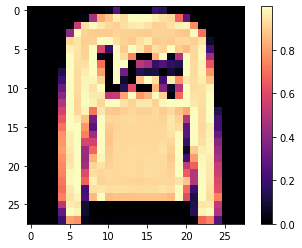

10 Steps:


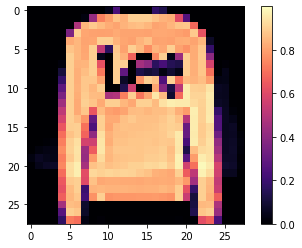

20 Steps:


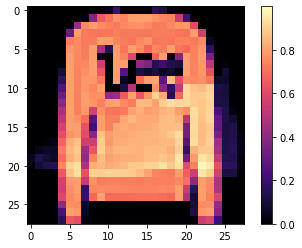

30 Steps:


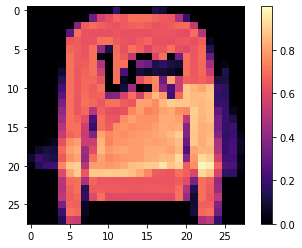

40 Steps:


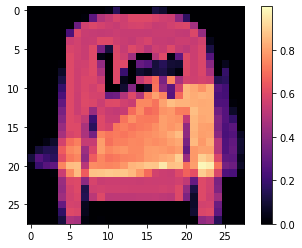

50 Steps:


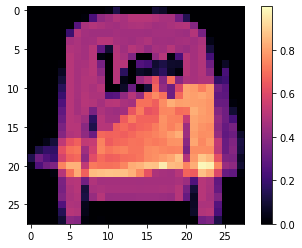

60 Steps:


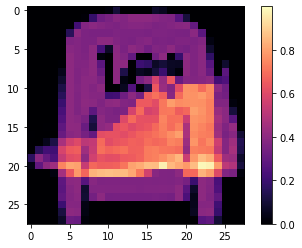

70 Steps:


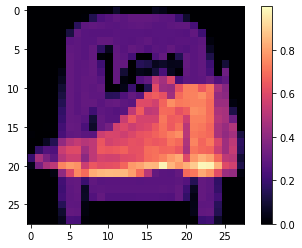

80 Steps:


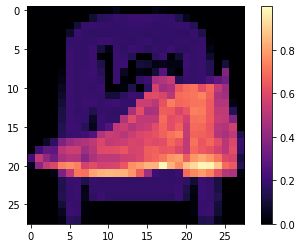

99 Steps:


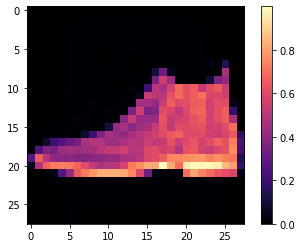

In [67]:
from integrated_gradients import _parameterize

baseline = test_images[1]

# Parameterize with our IG helper function
steps, step = _parameterize(ob=test_images[0], base=baseline, n_steps=100)

# We're going to see snapshots of the parameterization at 10-step intervals
intervals = [0, 10, 20, 30, 40, 50, 60, 70, 80, 99]

# Normalize color pallet, otherwise auto-normalization will kill the effect here
norm = matplotlib.colors.Normalize(vmin=min(np.asarray(steps[99]).flatten()), 
                                   vmax=max(np.asarray(steps[99]).flatten()), 
                                   clip=False)

for i in intervals:
    print('{} Steps:'.format(i))
    plt.figure()
    plt.imshow(steps[i], cmap='magma', norm=norm)
    plt.colorbar()
    plt.grid(False)
    plt.show()

See, we can set anything as the baseline! The resulting explanation is the answer to the question: "why did this observation score differently than this baseline?", or in our example "why did the model think this was a shoe instead of a shirt?"

Neat!

Now, let's try integrating the gradients along these paths! One of the gurantees of IG is that the resultant feature-wise explanation of a score should sum up to the difference in the model's scores at the baseline and observation of interest. Below we will see the actual explanation graphed, but first let's confirm this gurantee: 

1. As a useful sanity check, and...

2. To show the effect of increasing the number of steps on our integration path 

In [68]:
%%time
from integrated_gradients import integrate_gradients

# Set the number of steps for integration
n_steps = 100

# Define the baseline-- first, we will do an "all black" background
baseline = np.zeros((test_images[0].shape[0],test_images[0].shape[1]))

# Call IG-- reshape is necessary because of model batching size
explanation = integrate_gradients(ob=test_images[0].reshape(1, 28, 28), 
                                  base=baseline.reshape(1, 28, 28), 
                                  model=model,
                                  n_steps=n_steps)

# Get the score delta between the baseline and observation of interest
model_score_base = np.asarray(model(test_images[0].reshape(1, 28, 28)))
model_score_ob = np.asarray(model(baseline.reshape(1, 28, 28)))
score_delta = model_score_base-model_score_ob

# Compare score delta and explanation sum
print('Difference of model score between baseline and observation we are explaining: {}'.format(sum(np.asarray(score_delta).flatten())))
print('Sum of explanation (integrated gradients) with {} steps: {}'.format(n_steps, sum(np.asarray(explanation).flatten())))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Difference of model score between baseline and observation we are explaining: -9.494913816452026
Sum of explanation (integrated gradients) with 100 steps: -9.466785720062974
CPU times: user 711 ms, sys: 15.3 ms, total: 726 ms
Wall time: 949 ms


Hey that's pretty close! 

What if we were to **increase the number of steps?**

In [69]:
%%time 
n_steps = 1000
explanation = integrate_gradients(ob=test_images[0].reshape(1, 28, 28), 
                            base=baseline.reshape(1, 28, 28), 
                            model=model, 
                            n_steps=n_steps)
model_score_base = np.asarray(model(test_images[0].reshape(1, 28, 28)))
model_score_ob = np.asarray(model(baseline.reshape(1, 28, 28)))
score_delta = model_score_base-model_score_ob
print('Difference of model score between baseline and observation we are explaining: {}'.format(sum(np.asarray(score_delta).flatten())))
print('Sum of explanation (integrated gradients) with {} steps: {}'.format(n_steps, sum(np.asarray(explanation).flatten())))


Difference of model score between baseline and observation we are explaining: -9.494913816452026
Sum of explanation (integrated gradients) with 1000 steps: -9.492256063609656
CPU times: user 4.63 s, sys: 112 ms, total: 4.74 s
Wall time: 5.7 s


Took a little longer! But we're pretty much on the money here. Below we will show the input, the baseline, and the resulting explanation. 

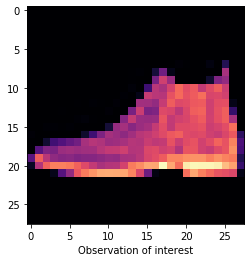

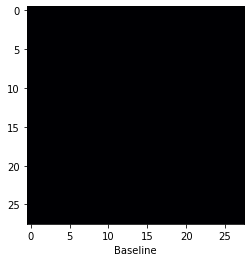

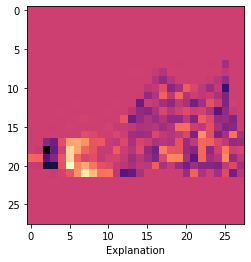

In [70]:
plt.figure()
plt.imshow(test_images[0], cmap='magma')
plt.xlabel('Observation of interest')
plt.figure()
plt.imshow(baseline, cmap='magma')
plt.xlabel('Baseline')
plt.figure()
plt.imshow(explanation[0], cmap='magma')
plt.xlabel('Explanation')
plt.show()

To reiterate though-- we don't need to use an all black baseline. Let's see the result of an explanation with a shirt reference (as above.)

In [71]:
from integrated_gradients import integrate_gradients

n_steps = 1000
baseline = test_images[1]
explanation = integrate_gradients(ob=test_images[0].reshape(1, 28, 28), 
                                  base=baseline.reshape(1, 28, 28), 
                                  model=model,
                                  n_steps=n_steps)

model_score_base = np.asarray(model(test_images[0].reshape(1, 28, 28)))
model_score_ob = np.asarray(model(baseline.reshape(1, 28, 28)))
score_delta = model_score_base-model_score_ob

print('Difference of model score between baseline and observation we are explaining: {}'.format(sum(np.asarray(score_delta).flatten())))
print('Sum of explanation (integrated gradients) with {} steps: {}'.format(n_steps, sum(np.asarray(explanation).flatten())))


Difference of model score between baseline and observation we are explaining: 3.2455339431762695
Sum of explanation (integrated gradients) with 1000 steps: 3.253151231290784


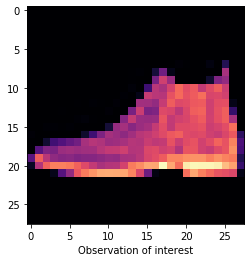

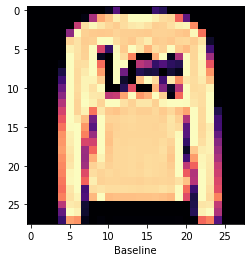

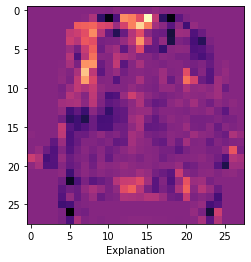

In [72]:
plt.figure()
plt.imshow(test_images[0], cmap='magma')
plt.xlabel('Observation of interest')
plt.figure()
plt.imshow(baseline, cmap='magma')
plt.xlabel('Baseline')
plt.figure()
plt.imshow(explanation[0], cmap='magma')
plt.xlabel('Explanation')
plt.show()

## Explanations Can Be Manipulated And Geometry Is To Blame

Implementation of [this](https://arxiv.org/abs/1906.07983) attack method for explanations. For details on the inner workings of the code, see `adversarial_explanations.py`.

Below we're going to check out the initial adversarial pattern (at the first iteration,) and then we'll try our hand at a fast-gradient descent attack for generating an adversarial explanation example for fashion MNIST.

Here we get the "initial" adversarial gradient-- before any perturbations are made to our point of interest. We can see the gradient overlayed at various intensity levels to see where the inital "push" we're giving our point is sending it. 

0


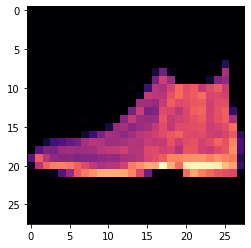

0.01


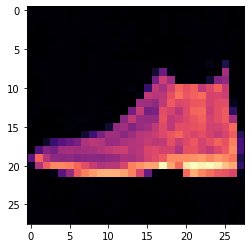

0.05


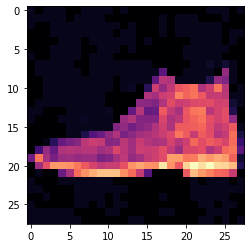

0.1


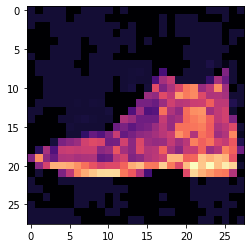

0.15


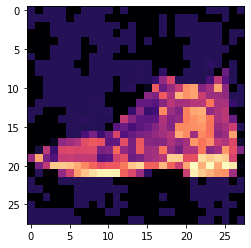

In [73]:
import copy
from adversarial_explanations import get_adv_gradients, create_adv_point

baseline = np.zeros((test_images[0].shape[0],test_images[0].shape[1]))

adv_pattern, losses = get_adv_gradients(model=model, 
                                ob=tf.convert_to_tensor(test_images[0].reshape((1, 28, 28))), 
                                alt=tf.convert_to_tensor(test_images[4].reshape((1, 28, 28))), 
                                base=tf.convert_to_tensor(baseline.reshape((1, 28, 28))), 
                                ob_orig=tf.convert_to_tensor(copy.deepcopy(test_images[0]).reshape((1, 28, 28))),
                                n_steps=50, 
                                delta=1, 
                                signed=True)

epsilons = [0, 0.01, 0.05, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    print(eps)
    adv_x = test_images[0] + eps*adv_pattern
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    plt.figure()
    plt.imshow(np.asarray(adv_x).reshape((28,28)), cmap='magma')
    plt.show()


Now, we can progressively calculate the gradient of our loss and iteratively subtract it from our original point to create adversarial examples whose predictions should remain constant and whose explanations are different. For implementation details, check out `adversarial_examples.py`.

In [ ]:
%%time
n_iter = 500
baseline = np.zeros((test_images[0].shape[0],test_images[0].shape[1]))

adv_point, losses = create_adv_point(model=model, 
                                     ob=test_images[0], 
                                     alt=test_images[4], 
                                     base=baseline, 
                                     n_iter=n_iter, 
                                     gradient_step=0.01, 
                                     n_steps=200, 
                                     delta=1)


Let's get the explanation of our newly created adversary. 

In [80]:
adv_expl = integrate_gradients(ob=adv_point, base=baseline.reshape((1, 28, 28)), model=model, n_steps=50)

Quickly the loss is heading in the right direction. Conversion is not necessary, we just want to be sure our gradient descent is working. 

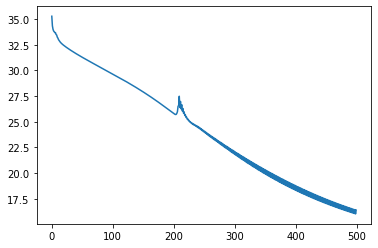

In [81]:
plt.plot(np.arange(n_iter), losses)
plt.show()

So, to refresh, this is our original point and our target point. We will try and manipulate our original point (the resulting manipulated point is the "adversary") such that its prediction should remain constant and its explanation matches our target. 

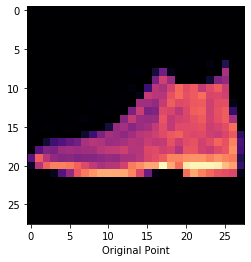

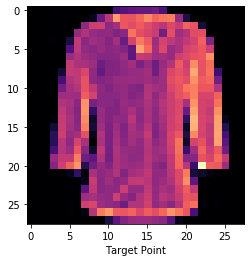

In [90]:
# Let's try it out!
# Here we're looking at the first and fifth images in the set
# (the first pants and shirt, respectively)
plt.figure()
plt.imshow(test_images[0], cmap='magma')
plt.xlabel('Original Point')
plt.figure()
plt.imshow(test_images[4], cmap='magma')
plt.xlabel('Target Point')
plt.show()

Now let's see our original, target, and adversarial explanations:

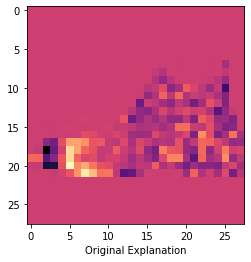

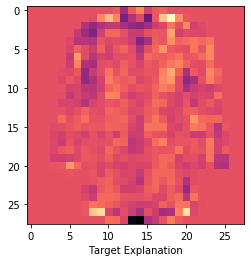

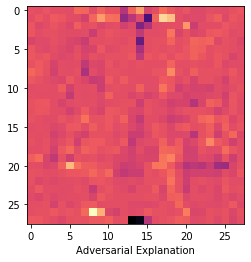

In [91]:
orig_expl = integrate_gradients(ob=test_images[0].reshape((1,28,28)), 
                                 base=baseline.reshape((1,28,28)), 
                                 model=model, 
                                 n_steps=50)
target_expl = integrate_gradients(ob=test_images[4].reshape((1,28,28)), 
                                   base=baseline.reshape((1,28,28)), 
                                   model=model, 
                                   n_steps=50)

plt.figure()
plt.imshow(np.asarray(orig_expl).reshape((28,28)), cmap='magma')
plt.xlabel('Original Explanation')
plt.figure()
plt.imshow(np.asarray(target_expl).reshape((28,28)), cmap='magma')
plt.xlabel('Target Explanation')
plt.figure()
plt.imshow(np.asarray(adv_expl).reshape((28,28)), cmap='magma')
plt.xlabel('Adversarial Explanation')
plt.show()

It closely matches out target!!

Again, let's see our original point, adversarial point, original explanation, and adversarial explanation:

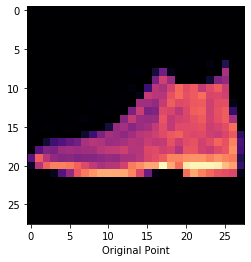

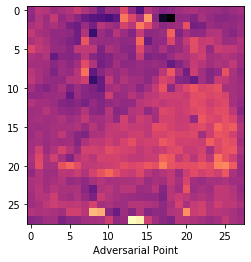

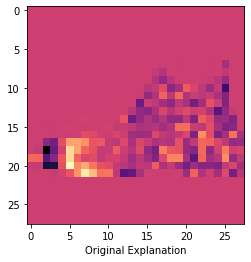

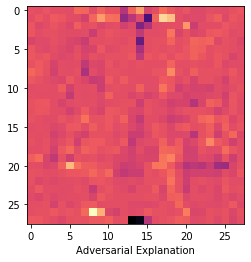

In [92]:
# Now let's see the manipualted point and its adversary
plt.figure()
plt.imshow(test_images[0], cmap='magma')
plt.xlabel('Original Point')
plt.figure()
plt.imshow(np.asarray(adv_point).reshape((28,28)), cmap='magma')
plt.xlabel('Adversarial Point')
plt.figure()
plt.imshow(np.asarray(orig_expl).reshape((28,28)), cmap='magma')
plt.xlabel('Original Explanation')
plt.figure()
plt.imshow(np.asarray(adv_expl).reshape((28,28)), cmap='magma')
plt.xlabel('Adversarial Explanation')
plt.show()

Keep in mind, this effect is much easier to spot in more complicated models (i.e. for imagenet)-- I was really surprised that I got such a cool example here. We can see that though it is messier, the adversarial point is fairly clearly an ankle boot while the explanation clearly seems to be a shirt!

**This is so cool.** It points to a potential weakness in the ML explainer, at least with this baseline. 

Try out this experiment with the beta-softplus (0.8) above! You'll need to retrain your model and run the above cells. It should be harder to find such adversarial examples. 

Below, we confirm that the model still believed our adversarial example was an ankle boot:


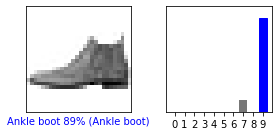

In [86]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

predictions = probability_model.predict(adv_point)

num_rows = 1
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()